# Setup and Imports

In [75]:
# !pip install lxml html5lib beautifulsoup4 # Might need to uncomment and run this if beautifulsoup4 isnt installed
# !pip install opencage # Might need to uncomment and install opencage
# !pip install folium # uncomment this line if you haven't completed the Foursquare API lab


import numpy as np
import pandas as pd
import time
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from opencage.geocoder import OpenCageGeocode
import matplotlib.pyplot as plt
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# Notes and Brief Road Map

-Usually I have a section for all functions near the top of the notebook, I will define the functions right before first use if there are any.

-We first scrape https://en.wikipedia.org/wiki/Table_of_Atlanta_neighborhoods_by_population for the list of neighborhoods and their population

-Using OpenCageGeocode, we can obtain the lat and long of each Atlanta Neighborhood.

-We make requests to FourSquare API to grab a list of venues for each Atlanta Neighborhood, this is of course just a sample of all venues in that neighborhood.

-Base on the number of venues and number of food venues, we make a threshold to exclude noncommercial neighborhoods.

-Counting the total number of food venues and number of Mexican food venues, we can compute the competition in that neighborhood.

-Cluster using competition and population

# Web Scraping

In [3]:
url = 'https://en.wikipedia.org/wiki/Table_of_Atlanta_neighborhoods_by_population'
dfs = pd.read_html(url) # we scrap the webpage and save multiple dataframes

In [4]:
atlanta_neighborhood_population_df = dfs[0].rename(columns={'Population (2010)':'Population'})\
                                           .drop('NPU', 1)\
                                           .loc[dfs[0]['Population (2010)'] >= 1500]\
                                           .sort_values(by=['Population'], axis=0, ascending=False)\
                                           .reset_index(drop=True)
atlanta_neighborhood_population_df

,Neighborhood,Population
0,Midtown,16569
1,Downtown,13411
2,Old Fourth Ward,10505
3,North Buckhead,8270
4,Pine Hills,8033
...,...,...
83,Ridgedale Park,1685
84,Kings Forest,1674
85,Lenox,1663
86,Mt. Paran/Northside,1568


# Latitude and Longitude

In [5]:
atlanta_neighborhood_population_df['Latitude'] = pd.Series(np.nan, index=atlanta_neighborhood_population_df.index)
atlanta_neighborhood_population_df['Longitude'] = pd.Series(np.nan, index=atlanta_neighborhood_population_df.index)

In [6]:
key = '29290842590d4f74916077e65837c8f5'
geocoder = OpenCageGeocode(key)

def grab_lat_long_atlanta_neighborhood(neighborhood, geocoderObj):
    query = neighborhood + ', Atlanta, Georgia'
    results = geocoderObj.geocode(query)
    
    return results[0]['geometry']['lat'], results[0]['geometry']['lng']

In [7]:
for index in atlanta_neighborhood_population_df.index:
    neighborhood = atlanta_neighborhood_population_df.iloc[index]['Neighborhood']
    latLong = grab_lat_long_atlanta_neighborhood(neighborhood, geocoder)
    atlanta_neighborhood_population_df.loc[index, 'Latitude'] = latLong[0]
    atlanta_neighborhood_population_df.loc[index, 'Longitude'] = latLong[1]
    time.sleep(2)
    print(neighborhood, 'Done!')

Midtown Done!
Downtown Done!
Old Fourth Ward Done!
North Buckhead Done!
Pine Hills Done!
Morningside/Lenox Park Done!
Virginia-Highland Done!
Grant Park Done!
Georgia Tech Done!
Kirkwood Done!
Atlanta University Center Done!
Collier Heights Done!
East Atlanta Done!
Home Park Done!
Grove Park Done!
Peachtree Heights West Done!
Campbellton Road Done!
Sylvan Hills Done!
Lindbergh Done!
West End Done!
Lindridge/Martin Manor Done!
Southwest Done!
Inman Park Done!
Glenrose Heights Done!
Ormewood Park Done!
Edgewood Done!
Garden Hills Done!
Chosewood Park Done!
Venetian Hills Done!
Mechanicsville Done!
Pittsburgh Done!
Greenbriar Done!
Oakland City Done!
Underwood Hills Done!
English Avenue Done!
Candler Park Done!
Fairburn Mays Done!
Center Hill Done!
Westview Done!
Bolton Done!
Vine City Done!
Peachtree Hills Done!
Thomasville Heights Done!
Paces Done!
Peoplestown Done!
East Lake Done!
Hammond Park Done!
Lake Claire Done!
Reynoldstown Done!
Knight Park/Howell Station Done!
Princeton Lakes D

In [8]:
atlanta_neighborhood_population_df

,Neighborhood,Population,Latitude,Longitude
0,Midtown,16569,33.781127,-84.386360
1,Downtown,13411,33.749055,-84.388171
2,Old Fourth Ward,10505,33.721420,-84.544224
3,North Buckhead,8270,33.839814,-84.379559
4,Pine Hills,8033,33.727565,-84.320646
...,...,...,...,...
83,Ridgedale Park,1685,33.753383,-84.321725
84,Kings Forest,1674,33.817827,-84.381042
85,Lenox,1663,33.845393,-84.358129
86,Mt. Paran/Northside,1568,33.895351,-84.386113


# Removing Some Venues

-Looking ahead, we see that the following list contains neighborhoods that returns less than 30 venues, we will go ahead and remove those.

-Also removing neighborhood that return less than 20 food venues.

-Some of theese neighborhoods have relatively high population, but must be not be commercially zoned.

In [9]:
removeList = ['Grant Park','Brookhaven (City of Atlanta)','Bolton','Old Fourth Ward','Candler Park','Kirkwood','Mt. Paran/Northside','Lake Claire','Atlanta University Center','Summerhill','Westview','Ridgedale Park','English Avenue','Mechanicsville','Chosewood Park','South Atlanta','Chastain Park','East Lake','Hunter Hills','Princeton Lakes','Adams Park','Adamsville','Fairburn Mays','Peachtree Hills','Mozley Park','Peoplestown','Grove Park','Ben Hill','Ormewood Park','Vine City','Cross Creek','Hammond Park','Capitol View','Center Hill','Oakland City','Piedmont Heights','Midwest Cascade','Perkerson','Pine Hills','Venetian Hills','Lakewood Heights','Morningside/Lenox Park','South River Gardens','Glenrose Heights','Garden Hills','Thomasville Heights','Carey Park','Bankhead','Greenbriar','Sylvan Hills','Pittsburgh','Harland Terrace','Collier Heights','Poncey-Highland','Browns Mill Park','Dixie Hills','Campbellton Road','Wildwood']

In [53]:
commercial_neighborhoods = atlanta_neighborhood_population_df.loc[~atlanta_neighborhood_population_df['Neighborhood'].isin(removeList)].reset_index(drop=True)
commercial_neighborhoods

,Neighborhood,Population,Latitude,Longitude
0,Midtown,16569,33.781127,-84.386360
1,Downtown,13411,33.749055,-84.388171
2,North Buckhead,8270,33.839814,-84.379559
3,Virginia-Highland,7800,33.782656,-84.353691
4,Georgia Tech,6607,33.776033,-84.398841
5,East Atlanta,5033,33.740106,-84.344925
6,Home Park,4941,33.782438,-84.397131
7,Peachtree Heights West,4767,33.753391,-84.390844
8,Lindbergh,4598,33.822754,-84.369549
9,West End,4270,33.740663,-84.427428


# Food Venues of Selected Neighborhoods in Atlanta

In [14]:
# Examining geographically, the radius of 1000 meters, which is more than half a mile; this is a good decision, because 1000 meters is still usually within the established area of each neighborhood.
# We're looking at the the total demand = the population of the neighborhood, the total competition = all existing "Mexican" restraunts/all restraunts in the neighborhood

def getNearbyFoodVenues(names, latitudes, longitudes, radius=1000): 
    
# These are left blank, in order to run them, you will have to use your own client_id and client_secret
    CLIENT_ID = '5DQ1PAXKNRWFFBEETB141PHZIF5TNK1QMZERZB21THXEX1MD' # your Foursquare ID
    CLIENT_SECRET = 'QG35VNEXIDC2WTSQBPXPV241J4WNR3MQFFSLJ0GBSG0AMIJ1' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    LIMIT = 100 # A default Foursquare API limit value
    categoryId = '4d4b7105d754a06374d81259' #4d4b7105d754a06374d81259 for food
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryId)
            
        # make the GET request
        res = requests.get(url).json()
        results = res["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [54]:
atlanta_food_venues = getNearbyFoodVenues(names=commercial_neighborhoods['Neighborhood'],
                                   latitudes=commercial_neighborhoods['Latitude'],
                                   longitudes=commercial_neighborhoods['Longitude']
                                  )

Midtown
Downtown
North Buckhead
Virginia-Highland
Georgia Tech
East Atlanta
Home Park
Peachtree Heights West
Lindbergh
West End
Lindridge/Martin Manor
Southwest
Inman Park
Edgewood
Underwood Hills
Paces
Reynoldstown
Knight Park/Howell Station
Cascade Avenue/Road
Ansley Park
Buckhead Forest
Brookwood Hills
East Chastain Park
Atlantic Station
Sweet Auburn
Brookwood
Loring Heights
Kings Forest
Lenox
Peachtree Battle Alliance


In [55]:
atlanta_food_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Midtown,33.781127,-84.38636,Cafe Agora,33.780932,-84.384460,Mediterranean Restaurant
1,Midtown,33.781127,-84.38636,Ecco Midtown,33.778827,-84.385988,Mediterranean Restaurant
2,Midtown,33.781127,-84.38636,Empire State South,33.781374,-84.383662,Southern / Soul Food Restaurant
3,Midtown,33.781127,-84.38636,Steamhouse Lounge,33.783410,-84.387644,Seafood Restaurant
4,Midtown,33.781127,-84.38636,Marlow's Tavern,33.780110,-84.387566,New American Restaurant


In [56]:
food_venue_count_for_each_neighborhood = atlanta_food_venues['Neighborhood'].value_counts()

In [57]:
# Make this a little bit easier by setting the "Neighborhood column to be the index"

commercial_neighborhoods = commercial_neighborhoods.set_index('Neighborhood')

In [58]:
for neighborhood in food_venue_count_for_each_neighborhood.index:
    commercial_neighborhoods.loc[neighborhood, 'Food Venue Count'] = food_venue_count_for_each_neighborhood[neighborhood]


In [59]:
atlanta_food_venues['Venue Category'].value_counts()

American Restaurant    121
Sandwich Place         113
Pizza Place            108
Restaurant              71
Café                    70
                      ... 
Malay Restaurant         1
Souvlaki Shop            1
Hawaiian Restaurant      1
Fish & Chips Shop        1
Creperie                 1
Name: Venue Category, Length: 81, dtype: int64

# Computing Competition

-existing competition = existing restaurants that serves tacos and burritos / all existing restaurants

-From https://developer.foursquare.com/docs/build-with-foursquare/categories/, we're combining Mexican Restaurant, Botanero, Burrito Place, Taco Place, Tex-Mex Restaurant, Yucatecan Restaurant together

In [60]:
mexican_categories = ['Mexican Restaurant', 'Botanero', 'Burrito Place', 'Taco Place', 'Tex-Mex Restaurant', 'Yucatecan Restaurant']

mexican_venue_count_for_each_neighborhood = atlanta_food_venues.loc[atlanta_food_venues['Venue Category'].isin(mexican_categories)].groupby(['Neighborhood']).count()[['Venue Category']]

In [61]:
commercial_neighborhoods['Mexican Venue Count'] = pd.Series(0, index=commercial_neighborhoods.index)
commercial_neighborhoods['Mexican Competition'] = pd.Series(0, index=commercial_neighborhoods.index)

In [62]:
for neighborhood in mexican_venue_count_for_each_neighborhood.index:
    commercial_neighborhoods.loc[neighborhood, 'Mexican Venue Count'] = mexican_venue_count_for_each_neighborhood.loc[neighborhood, 'Venue Category']
    commercial_neighborhoods.loc[neighborhood, 'Mexican Competition'] = commercial_neighborhoods.loc[neighborhood, 'Mexican Venue Count'] / commercial_neighborhoods.loc[neighborhood, 'Food Venue Count']
    
commercial_neighborhoods

,Population,Latitude,Longitude,Food Venue Count,Mexican Venue Count,Mexican Competition
Neighborhood,,,,,,
Midtown,16569,33.781127,-84.386360,100.0,9,0.090000
Downtown,13411,33.749055,-84.388171,67.0,3,0.044776
North Buckhead,8270,33.839814,-84.379559,82.0,5,0.060976
Virginia-Highland,7800,33.782656,-84.353691,27.0,2,0.074074
Georgia Tech,6607,33.776033,-84.398841,59.0,2,0.033898
East Atlanta,5033,33.740106,-84.344925,37.0,2,0.054054
Home Park,4941,33.782438,-84.397131,85.0,3,0.035294
Peachtree Heights West,4767,33.753391,-84.390844,100.0,4,0.040000
Lindbergh,4598,33.822754,-84.369549,29.0,0,0.000000


# Preprocessing and KMeans Clustering

In [63]:
# Normalize our dataset

X = commercial_neighborhoods[['Population', 'Mexican Competition']]

kmeans_df = StandardScaler().fit_transform(X)

Visual examination

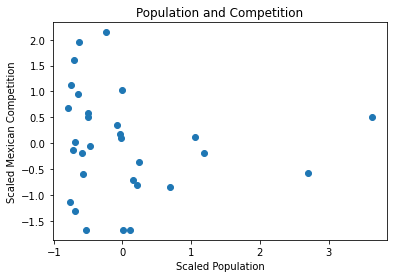

In [64]:
scaled_features_df = pd.DataFrame(kmeans_df, index=commercial_neighborhoods.index, columns=['Scaled Population', 'Scaled Mexican Competition'])

plt.scatter(scaled_features_df['Scaled Population'], scaled_features_df['Scaled Mexican Competition'], marker='o')
plt.title('Population and Competition')
plt.xlabel('Scaled Population')
plt.ylabel('Scaled Mexican Competition')
plt.show()

In [65]:
# Let's do elbow method to find the best k

inertias = [] 
in_map = {} 
K = range(1,20) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k, random_state=42) 
    kmeanModel.fit(kmeans_df)     
    
    inertias.append(kmeanModel.inertia_) 
    in_map[k] = kmeanModel.inertia_ 

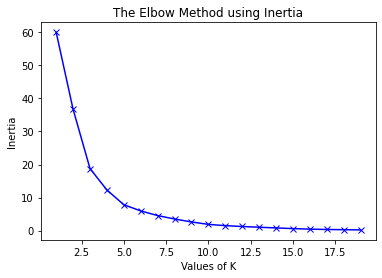

In [66]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

-The right k seems to be 5, and hopefully once the grouping has been done, the groups can be easily interpreted

In [67]:
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(kmeans_df)
cluster_labels = pd.DataFrame({'cluster label': kmeans.labels_}, columns=['cluster label'])

commercial_neighborhoods['cluster label'] = pd.Series(0, index=commercial_neighborhoods.index)
for index in cluster_labels.index:
    commercial_neighborhoods.iloc[index, 6] = cluster_labels.loc[index, 'cluster label']

commercial_neighborhoods = commercial_neighborhoods.merge(scaled_features_df, left_index=True, right_index=True).sort_values(by=['cluster label'])
    
commercial_neighborhoods

,Population,Latitude,Longitude,Food Venue Count,Mexican Venue Count,Mexican Competition,cluster label,Scaled Population,Scaled Mexican Competition
Neighborhood,,,,,,,,,
Peachtree Battle Alliance,1540,33.820079,-84.389349,31.0,3,0.096774,0,-0.796185,0.681598
Loring Heights,1774,33.798716,-84.397983,63.0,4,0.063492,0,-0.727201,-0.128267
Sweet Auburn,1882,33.755502,-84.380213,100.0,7,0.070000,0,-0.695362,0.030092
Buckhead Forest,2252,33.839814,-84.379559,82.0,5,0.060976,0,-0.586285,-0.189501
Knight Park/Howell Station,2545,33.753382,-84.369774,100.0,9,0.090000,0,-0.499908,0.516759
Reynoldstown,2550,33.749049,-84.356101,43.0,4,0.093023,0,-0.498434,0.590325
Southwest,4158,33.748992,-84.390264,55.0,4,0.072727,0,-0.024390,0.096456
Inman Park,4098,33.757606,-84.362704,79.0,6,0.075949,0,-0.042078,0.174860
Edgewood,3983,33.761773,-84.341314,36.0,3,0.083333,0,-0.075981,0.354537


Visualizing Again

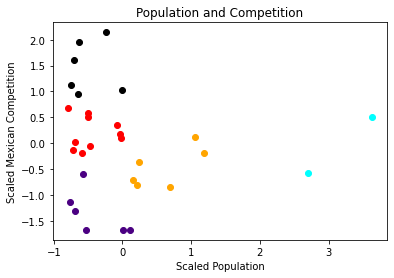

In [86]:
cluster0 = commercial_neighborhoods.loc[commercial_neighborhoods['cluster label'] == 0][['Scaled Population', 'Scaled Mexican Competition']]
cluster1 = commercial_neighborhoods.loc[commercial_neighborhoods['cluster label'] == 1][['Scaled Population', 'Scaled Mexican Competition']]
cluster2 = commercial_neighborhoods.loc[commercial_neighborhoods['cluster label'] == 2][['Scaled Population', 'Scaled Mexican Competition']]
cluster3 = commercial_neighborhoods.loc[commercial_neighborhoods['cluster label'] == 3][['Scaled Population', 'Scaled Mexican Competition']]
cluster4 = commercial_neighborhoods.loc[commercial_neighborhoods['cluster label'] == 4][['Scaled Population', 'Scaled Mexican Competition']]

plt.scatter(cluster0['Scaled Population'], cluster0['Scaled Mexican Competition'], marker='o', color='red')
plt.scatter(cluster1['Scaled Population'], cluster1['Scaled Mexican Competition'], marker='o', color='indigo')
plt.scatter(cluster2['Scaled Population'], cluster2['Scaled Mexican Competition'], marker='o', color='cyan')
plt.scatter(cluster3['Scaled Population'], cluster3['Scaled Mexican Competition'], marker='o', color='black')
plt.scatter(cluster4['Scaled Population'], cluster4['Scaled Mexican Competition'], marker='o', color='orange')
plt.title('Population and Competition')
plt.xlabel('Scaled Population')
plt.ylabel('Scaled Mexican Competition')
plt.show()

-clusters 1, 2 and 4 are interesting

-there are low population neighborhoods of varying competitions, those should not be considered

-of course, higher population and lower competition is best.

# Examining the Clusters Geographically

In [89]:
commercial_neighborhoods_interest = commercial_neighborhoods.loc[commercial_neighborhoods['cluster label'].isin([1,2,4])]

latitude = 33.7490
longitude = -84.3880

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(commercial_neighborhoods_interest['Latitude'], commercial_neighborhoods_interest['Longitude'], commercial_neighborhoods_interest.index, commercial_neighborhoods_interest['cluster label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

-Final recommendations are Home Park and Midtown

-Midtown has high population and median competition; it is located geographically next to Home Park

-Georgia Tech has median population and low competition, but the community may be isolated (specifically for the students)

-Home Park has low population and low competition, but it is located geographically next to Midtown